# Bayesian Neural Networks for Regression in NumPyro
Joshua Simmons - DARE - 10/2023

This notebook provides builds on the basic NumPyro BNN example (https://num.pyro.ai/en/stable/examples/bnn.html) to give some sample code to demonstrate the use of Bayesian neural networks in NumPyro.
The code uses both a direct approach to defining the NN architecture and flax.

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

# basic
import numpy as np
import pandas as pd

# custom functions
from functions.numpyro_utils import plot_prediction, calc_mean_hpdi, plot_prediction_scatter

import numpy as np
# NumPyro for proabilistic programming
import arviz as az
import jax
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.contrib.module import random_flax_module, flax_module
from numpyro.infer import MCMC, NUTS, Predictive, init_to_sample
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal, AutoLaplaceApproximation, AutoMultivariateNormal

import flax
from flax import linen as nn

import matplotlib.pyplot as plt

from tqdm import tqdm


# Example data
We are going to keep it really simple and generate some univariate synthetic data using a polynomial with error.

In [3]:
# From NumPyro docs create artificial regression dataset
def get_data(N=50, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]

    mean_Y = jnp.mean(Y)
    std_Y = jnp.std(Y)

    Y -= mean_Y
    Y /= std_Y

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = jnp.linspace(-1.3, 1.3, N_test)
    X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))
    Y_test = jnp.dot(X_test, W) + 0.5 * jnp.power(0.5 + X_test[:, 1], 2.0) * jnp.sin(4.0 * X_test[:, 1])
    Y_test -= mean_Y
    Y_test /= std_Y
    
    return X, Y, X_test, Y_test


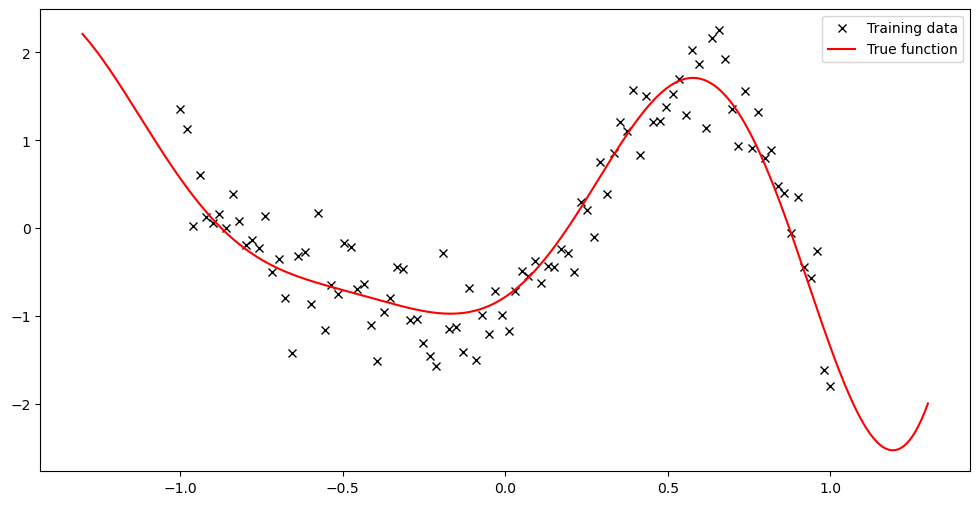

In [4]:
n_samples = 100
input_dim = 3

# generate the data (Y_test is not really relevant but just usde to check)
X, Y, X_test, Y_test = get_data(N=n_samples, sigma_obs=0.1, D_X=input_dim)

# plot the data
plt.figure(figsize=(12, 6))
plt.plot(X[:,1], Y, "kx", label="Training data")
plt.plot(X_test[:,1], Y_test, "r", label="True function")
plt.legend()
plt.show()


In [5]:
# Prepare the data for the BNN
jnp_X = jnp.array(X[:,1:2])
jnp_Y = jnp.array(Y) # ensure shape (N,1)

# dataframe for plotting
data_df = pd.DataFrame(index= jnp_X.squeeze(), data= jnp_Y, columns=['Y'])

print('jnp_X.shape: {}, isnan: {}'.format(jnp_X.shape, np.isnan(jnp_X).sum()))
print('jnp_Y.shape: {}, isnan: {}'.format(jnp_Y.shape, np.isnan(jnp_Y).sum()))

jnp_X.shape: (100, 1), isnan: 0
jnp_Y.shape: (100, 1), isnan: 0


# Define the BNN model for NumPyro

Here we will define a fixed sie for hidden layer 1 and hidden layer 2. (This could be coded up better to allow for different sizes to be trialled).

In [6]:
hidden_1 = 8
hidden_2 = 4
ci = 0.89 # confidence interval

In [7]:
# the non-linearity we use in our neural network
def nonlin(x):
    # Could also use relu with: jax.nn.relu(x)
    return jnp.tanh(x)

In [8]:
def bnn_model(X, Y = None):
    '''
    Model description: Bayesian Neural Network
    Here we implement a simple BNN with 2 hidden layers. 
    '''
    X_shape = X.shape[1]

    # # Define the priors as independent gaussians
    w1 = numpyro.sample("w1", dist.Normal(0,1).expand([X_shape, hidden_1]))
    b1 = numpyro.sample("b1", dist.Normal(0,1).expand([hidden_1]))
    w2 = numpyro.sample("w2", dist.Normal(0,1).expand([hidden_1, hidden_2]))
    b2 = numpyro.sample("b2", dist.Normal(0,1).expand([hidden_2]))
    w3 = numpyro.sample("w3", dist.Normal(0,1).expand([hidden_2, 1]))
    b3 = numpyro.sample("b3", dist.Normal(0,1).expand([1]))

    sigma_meas = numpyro.sample("sigma_meas", dist.Exponential(1))

    # NN forward pass
    z1 = nonlin(jnp.matmul(X, w1) + b1)  # <= first layer of activations
    z2 = nonlin(jnp.matmul(z1, w2) + b2)  # <= second layer of activations
    mu = jnp.matmul(z2, w3) + b3 # <= output layer

    with numpyro.plate("data", X.shape[0]):
        # record our mean model prediction
        numpyro.deterministic('mu',mu)
        # and define the likelihood function
        numpyro.sample("obs", dist.Normal(mu, sigma_meas).to_event(1), obs=Y)

In [9]:
class BasicBNN(nn.Module):

    @nn.compact
    def __call__(self, input_x):
        h1 = nn.Dense(hidden_1,use_bias=True)(input_x)
        h1 = nn.tanh(h1)
        h2 = nn.Dense(hidden_2,use_bias=True)(h1)
        h2 = nn.tanh(h2)
        out = nn.Dense(1,use_bias=True)(h2)
        return out
    
def bnn_flax_model(X, Y=None):
    flax_priors = {
        'Dense_0.kernel': dist.Normal(0,1),
        'Dense_0.bias': dist.Normal(0,1),
        'Dense_1.kernel': dist.Normal(0,1),
        'Dense_1.bias': dist.Normal(0,1),
        'Dense_2.kernel': dist.Normal(0,1),
        'Dense_2.bias': dist.Normal(0,1),
    }
    
    flax_bnn = random_flax_module(
        "flax_bnn", 
        BasicBNN(),
        input_shape=(X.shape),
        prior=flax_priors
    )

    sigma_meas = numpyro.sample("sigma_meas", dist.Exponential(1))

    mu = flax_bnn(X)
    
    with numpyro.plate("data", X.shape[0]):
        # record our mean model prediction
        numpyro.deterministic('mu',mu)
        # and define the likelihood function
        numpyro.sample("obs", dist.Normal(mu, sigma_meas).to_event(1), obs=Y)

# Prior checking
Now lets sample from out prior distributions, check what these look like with arviz. We will also check what our predictions look like from the priors to ensure we aren't assuming anything too silly.

In [10]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2102)
# here take 100 samples from our priors and make predictions
prior_samples = Predictive(bnn_model, num_samples=200)(
    rng_key_, X=jnp_X, Y=None
)
prior_samples = {k: jnp.expand_dims(v,axis=0) for k, v in prior_samples.items()}
# and put this into arviz for easy plotting
arviz_priors = az.from_dict(
    prior=prior_samples
)

# get the mean model prediciton and CI
mean_mu_prior = jnp.mean(arviz_priors.prior['mu'].values.squeeze(), axis=0)
hpdi_mu_prior = hpdi(arviz_priors.prior['mu'].values.squeeze(), ci)
hpdi_sim_prior = hpdi(arviz_priors.prior['obs'].values.squeeze(), ci)

arviz_priors

Inference data with groups:
	> prior

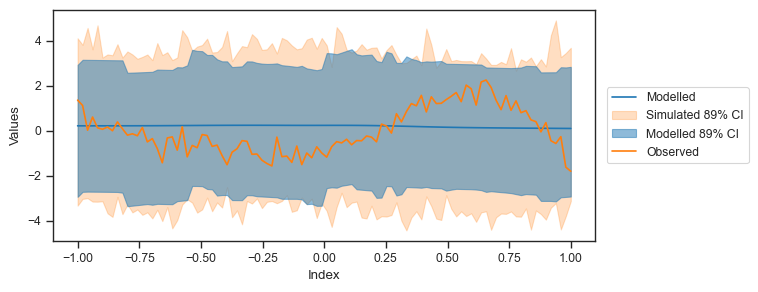

In [11]:
plot_prediction(data_df['Y'],mean_mu_prior,hpdi_mu_prior,hpdi_sim_prior,ci=ci)

# MCMC Sampling

We show examples using the No U-Turn Sampler (NUTS) and (the much more efficient MCMC approximation) SVI to sample from our posterior distributions. 
For MCMC we will sample `num_samples` times form the posterior, with `num_warmup` samples taken and discarded before we start proper. For SVI we will take `num_steps` steps of gradient descent.

Below is a generic setup that allows for the testing of multiple models via specifying `kernels_models`. 

In [12]:
# settings 
sampler = 'NUTS' # NUTS or SVI
# MCMC
num_samples = 1000
num_warmup = 1000
num_chains = 4
# max_tree = 10

# SVI
step_size = 0.01 
num_steps = 5000

# common settings
subsample_size = 32 # None if no batching

extract_vars = ['mu', 'obs','sigma_meas'] # variables to extract from posterior_predictive

# little bit of trickery to align the names of parameters in the bnn_model to the flax_bnn_model
flax_rename = {
    'flax_bnn/Dense_{}.{}'.format(layername, typename): '{}{}'.format(parname,layername+1) 
    for typename, parname in zip(['kernel','bias'],['w','b']) for layername in [0,1,2]
}
flax_bnn_params = list(flax_rename.keys())
# parameters to plot
check_vars = {
    'bnn_model': [
        'w1', 'b1', 'w2', 'b2', 'w3', 'b3',
    ] + extract_vars,
    'bnn_flax_model': flax_bnn_params + extract_vars
}


# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(143)

# specify the kernel (MCMC) or guide (SVI)
if sampler == 'NUTS':
    # define the sampler - No U-Turn Sampler (NUTS) for each model
    # give a list with the NUTS sampler and the model
    kernels_models = {
        'bnn_model': [
            NUTS(bnn_model),#max_tree_depth=max_tree
            bnn_model
        ],
        'bnn_flax_model': [
            NUTS(bnn_flax_model),#max_tree_depth=max_tree
            bnn_flax_model
        ]
    }
elif sampler == 'SVI':
    #SVI
    # You may have to try some things here - AutoNormal may fail, AutoLaplaceApproximation may be overconfident...
    kernels_models = {
        'bnn_model': [
            AutoNormal(
                bnn_model,
                init_loc_fn=init_to_sample
            ),
            bnn_model
        ],
        'bnn_flax_model': [
            AutoNormal(
                bnn_flax_model,
                init_loc_fn=init_to_sample
            ),
            bnn_flax_model
        ]
    }
else:
    raise ValueError('Sampler must be MCMC or SVI')

# create storage
mcmc_outputs = {_: {} for _ in kernels_models.keys()}


for kern_name, this_kern in kernels_models.items():
    print('Running model: {}'.format(kern_name))
    if sampler == 'NUTS':
        ######## NUTS
        # now run the sampler for num_samples+burnin
        this_model = this_kern[1]
        mcmc_obj = MCMC(this_kern[0], num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
        mcmc_obj.run(rng_key_, X = jnp_X, Y = jnp_Y)

        # get the samples which will form our posterior
        samples = mcmc_obj.get_samples()

        # get the samples for predictive uncertainty (our linear model + error)
        posterior_predictive = Predictive(
            this_model, posterior_samples=samples, 
            return_sites=check_vars[kern_name]
        )(rng_key_, X = jnp_X, Y = None)

        if 'flax' in kern_name:
            # cheeky switch out here to make flax go into arviz nicely
            arviz_posterior = az.from_dict(
                {flax_rename[k] if k in flax_rename.keys() else k: jnp.expand_dims(v, 0) for k, v in posterior_predictive.items()},
                posterior_predictive={flax_rename[k] if k in flax_rename.keys() else k: jnp.expand_dims(v, 0) for k, v in posterior_predictive.items()},
            )
        else:
            # create an arviz object
            arviz_posterior = az.from_numpyro(
                mcmc_obj,
                posterior_predictive=posterior_predictive,
                prior=prior_samples
            )
    elif sampler == 'SVI':
        ######## SVI
        # create a guide for SVI
        elbo = Trace_ELBO(num_particles=num_chains)
        optimizer = numpyro.optim.ClippedAdam(step_size=step_size,clip_norm=10.0)
        guide = this_kern[0]
        this_model = this_kern[1] 
        
        # run with all
        svi = SVI(
            model=this_model, guide=guide , optim=optimizer, loss=elbo, 
            X = jnp_X, Y = jnp_Y
        )
        svi_result = svi.run(rng_key_, num_steps)
        params = svi_result.params
        losses = svi_result.losses

        # SVI get samples using the guide
        predictive = Predictive(guide, params=params, num_samples=num_steps)
        samples = predictive(rng_key_, X = jnp_X, Y = None)

        # Now get the posterior predictive outputs using the samples and the model
        posterior_predictive = Predictive(
            this_model, posterior_samples=samples, num_samples=num_steps, return_sites=check_vars[kern_name]
        )(rng_key_, X = jnp_X, Y = None)

        if 'flax' in kern_name:
            # cheeky switch out here to make flax go into arviz nicely
            arviz_posterior = az.from_dict(
                {flax_rename[k] if k in flax_rename.keys() else k: jnp.expand_dims(v, 0) for k, v in posterior_predictive.items()},
                posterior_predictive={flax_rename[k] if k in flax_rename.keys() else k: jnp.expand_dims(v, 0) for k, v in posterior_predictive.items()},
            )
        else:
            arviz_posterior = az.from_dict(
                {k: jnp.expand_dims(v, 0) for k, v in posterior_predictive.items()},
                posterior_predictive={k: jnp.expand_dims(v, 0) for k, v in posterior_predictive.items()},
            )

    ###### Get model predictions
    # get the mean model prediciton and use hpdi 
    # to compute the credible intervals corresponding to ci
    mean_mu, hpdi_mu, hpdi_sim = calc_mean_hpdi(
        arviz_posterior, ci=ci, y_scaler=None, mu_var='mu'
    )

    mcmc_outputs[kern_name] = {
        'arviz_posterior': arviz_posterior,
        'mean_mu': mean_mu.squeeze(),
        'hpdi_mu': hpdi_mu.squeeze(),
        'hpdi_sim': hpdi_sim.squeeze()
    }

Running model: bnn_model


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running model: bnn_flax_model


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
# this should be adapted to check all of the models run
if sampler == 'NUTS':
    # if NUTS then check rhat etc
    mcmc_obj.print_summary()
elif sampler == 'SVI':
    # else plot loss curve
    fig = plt.figure(figsize=(5,2))
    ax = fig.add_subplot(111)
    ax.plot(losses[100:])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Log ELBO')
    ax.set_title('Convergence of SVI')
    # set y as logscale
    ax.set_yscale('log')
    plt.show()


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
    flax_bnn/Dense_0.bias[0]     -0.08      1.10     -0.13     -1.91      1.66    834.85      1.00
    flax_bnn/Dense_0.bias[1]      0.01      1.07      0.01     -1.60      1.85    915.06      1.01
    flax_bnn/Dense_0.bias[2]     -0.01      1.09     -0.06     -1.79      1.82    827.23      1.00
    flax_bnn/Dense_0.bias[3]     -0.01      1.09     -0.05     -1.82      1.75   1026.20      1.00
    flax_bnn/Dense_0.bias[4]      0.03      1.08      0.04     -1.78      1.79    986.41      1.00
    flax_bnn/Dense_0.bias[5]     -0.01      1.09     -0.03     -1.72      1.82   1017.22      1.00
    flax_bnn/Dense_0.bias[6]      0.00      1.08     -0.00     -1.76      1.74    926.56      1.00
    flax_bnn/Dense_0.bias[7]     -0.01      1.09     -0.04     -1.76      1.85   1103.35      1.00
flax_bnn/Dense_0.kernel[0,0]      0.03      1.32      0.02     -1.87      2.43    641.25      1.00
flax_bnn/

Check the some weights in the bnn_model vs the prior to check we have learned from the data

################################################################################
Posterior


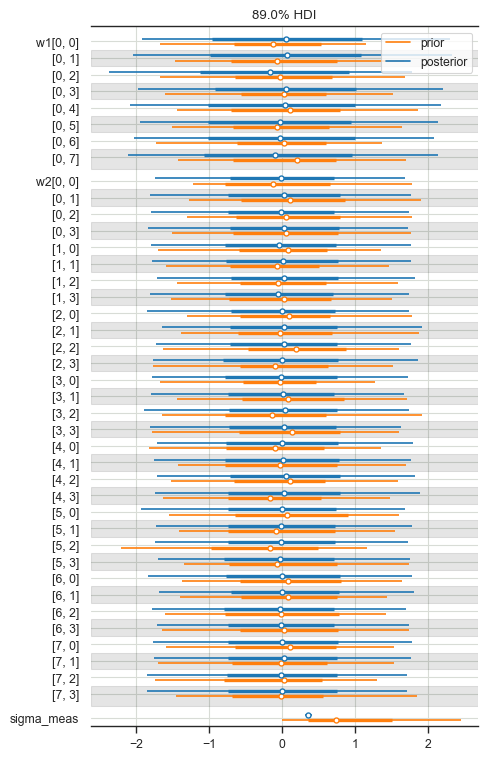

In [14]:
this_model = 'bnn_model'
print('#'*80)
print('Posterior')
# sns.set_context('talk')
x_range = 1.5
fig = plt.figure(figsize=(5,20))
ax1 = plt.subplot(211)
az.plot_forest(
    [
        mcmc_outputs[this_model]['arviz_posterior'],
        arviz_priors.prior
    ],
    var_names=['w1','w2','sigma_meas'],
    model_names=['posterior','prior'],
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
# turn on grid black with alpha 0.5 for this ax1
ax1.grid(color='xkcd:light grey')
None

Compare the posteriors for the flax model vs the direct implementation in NumPyro

################################################################################
Posterior


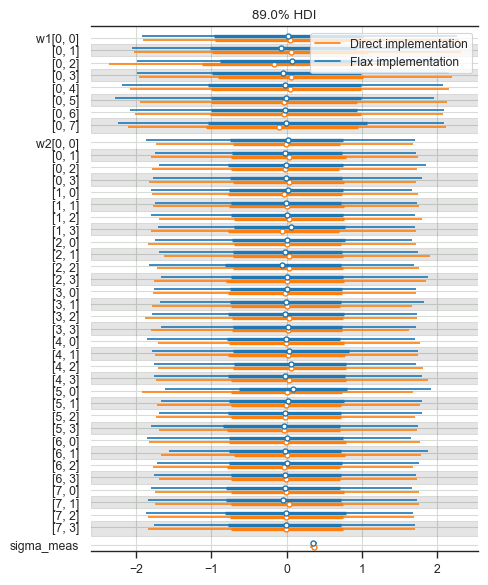

In [15]:
this_model1 = 'bnn_flax_model'
this_model2 = 'bnn_model'
print('#'*80)
print('Posterior')
# sns.set_context('talk')
x_range = 1.5
fig = plt.figure(figsize=(5,15))
ax1 = plt.subplot(211)
az.plot_forest(
    [
        mcmc_outputs[this_model1]['arviz_posterior'],
        mcmc_outputs[this_model2]['arviz_posterior']
    ],
    var_names=['w1','w2', 'sigma_meas'],
    hdi_prob=ci,
    model_names=['Flax implementation','Direct implementation'],
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
# turn on grid black with alpha 0.5 for this ax1
ax1.grid(color='xkcd:light grey')
None

# Plot the results

We can now plot our model predictions with uncertainty for our selected credible interval (`ci`) - say 89%. Notice that we plot two uncertainty bands, the first is the credible interval for our linear model (blue bands). Essentially, what are range of parameter values that our regression fit could have. 

However, we also have the $\sigma$ parameter. The predictive uncertainty (credible interval given by the orange bands) incorporates model uncertainty and the error ($\epsilon$) which describes our data (which we have assumed to be of the form $\mathcal{N}(0,\sigma)$). 

Here we are simulating possible values of actual data points, as opposed to just the range of possible regression predictions. This range reflects the shoreline change we could expect for a new event if measured by Coastsat data, rather than our modelled prediction of actual shoreline change. These bands should include approximately 89% of our data points, i.e. approximately matching the `ci` we have chosen.

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

def print_skill(models, df, mu_var='mean_mu'):
    # Calculate BSS, RMSE and R and print each for the models in models
    for this_mod in models.keys():
        rmse = np.sqrt(mean_squared_error(df['Y'],models[this_mod][mu_var]))
        r2 = r2_score(df['Y'],models[this_mod][mu_var])
        print('{} - : RMSE: {:.2f}, R2: {:.2f}'.format(this_mod,rmse,r2))

In [17]:
# report the RMSE and R2 on training dataa
print_skill(mcmc_outputs,data_df)

bnn_model - : RMSE: 0.34, R2: 0.88
bnn_flax_model - : RMSE: 0.34, R2: 0.88


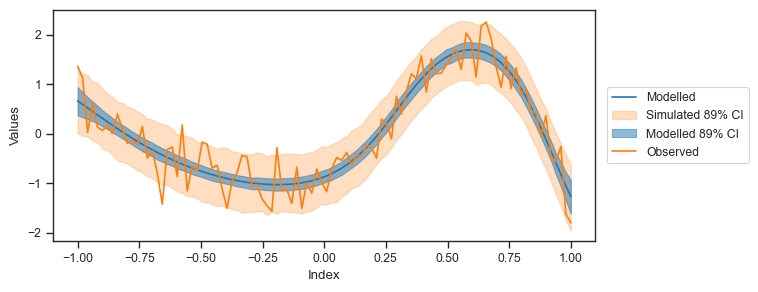

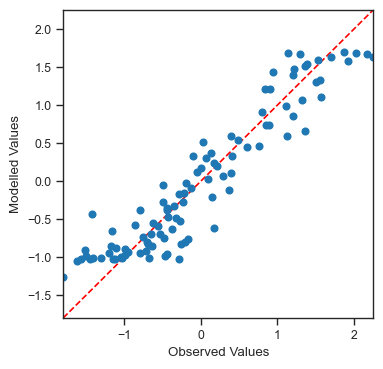

In [18]:
this_model = 'bnn_model'
plot_prediction(
    data_df['Y'],
    mcmc_outputs[this_model]['mean_mu'],
    mcmc_outputs[this_model]['hpdi_mu'],
    mcmc_outputs[this_model]['hpdi_sim'],
    ci=ci
)

plot_prediction_scatter(
    data_df['Y'].interpolate().values,
    mcmc_outputs[this_model]['mean_mu'],
    None,
    None,
    ci=ci
)
None

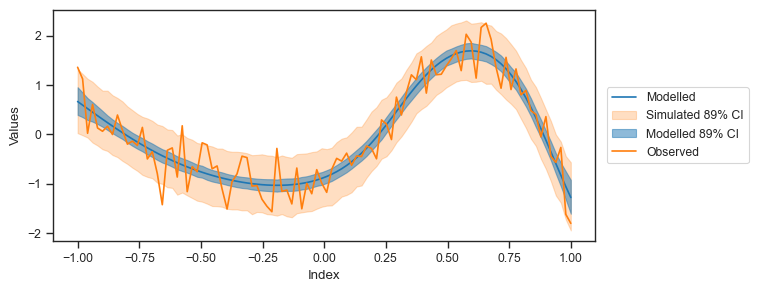

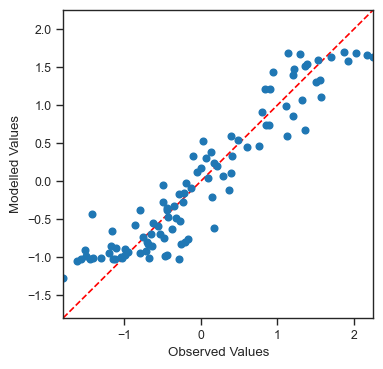

In [19]:
this_model = 'bnn_flax_model'
plot_prediction(
    data_df['Y'],
    mcmc_outputs[this_model]['mean_mu'],
    mcmc_outputs[this_model]['hpdi_mu'],
    mcmc_outputs[this_model]['hpdi_sim'],
    ci=ci
)

plot_prediction_scatter(
    data_df['Y'].interpolate().values,
    mcmc_outputs[this_model]['mean_mu'],
    None,
    None,
    ci=ci
)
None